BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly
   
    #Connect to remote data
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/My Drive/Kaggle

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [44]:
# Import Block
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from plotly.express import scatter_mapbox

In [3]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')
        
    # Build new Pump Age feature
    df['pump_age'] = pd.to_datetime(df['date_recorded']).dt.year - pd.to_datetime(df['construction_year']).dt.year
    df.drop(columns=['date_recorded'], inplace=True)

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop duplicate columns
    #automatic method is too unreliable
    #dupe_cols = [col for col in df.head(50).T.duplicated().index
    #             if df.head(50).T.duplicated()[col]]
    dupe_cols = ['subvillage', 'region', 'extraction_type_group', 'payment', 
                 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group']
    df.drop(columns=dupe_cols, inplace=True)    

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [32]:
df = wrangle("train_features.csv", "train_labels.csv")
X_test = wrangle("test_features.csv")

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [5]:
X = df.drop(columns=['status_group'])
y = df['status_group']

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [7]:
model_dum = DummyClassifier(strategy='prior').fit(X_train, y_train)
baseline_acc = accuracy_score(y, model_dum.predict(X))
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5429828068772491


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [8]:
# RF ensemble using values from best model from previous module

model = make_pipeline(OrdinalEncoder(), SimpleImputer(strategy='median'), RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=65, 
                                                                                                    min_samples_split=7, min_samples_leaf=1, 
                                                                                                    max_leaf_nodes=2900, max_features=0.425, 
                                                                                                    max_depth=32, criterion='entropy'))

model.fit(X_train, y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quantity', 'source',
                                      'source_class', 'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyi...
                                          'mapping': hand pump                      1
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                 

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [9]:
training_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9269235827962646
Validation Accuracy Score: 0.803766835016835


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

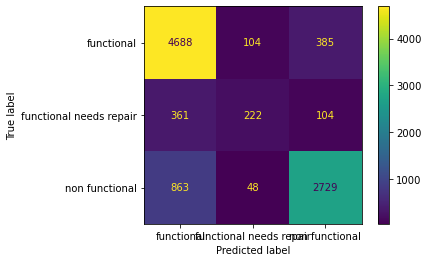

In [40]:
# Plot 3x3 confusion matrix
plot_confusion_matrix(model, X_val, y_val, values_format='.0f', display_labels=model.classes_)

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [42]:
# Print classification report
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      5177
functional needs repair       0.59      0.32      0.42       687
         non functional       0.85      0.75      0.80      3640

               accuracy                           0.80      9504
              macro avg       0.74      0.66      0.69      9504
           weighted avg       0.80      0.80      0.80      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [38]:
print(model.classes_)
X_test_nf = X_test.loc[model.predict_proba(X_test)[:,2] > 0.95]
print(X_test_nf.shape)

['functional' 'functional needs repair' 'non functional']
(1794, 24)


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [39]:
X_test_nf = X_test_nf.sort_values(by='population', ascending=False, na_position='last').head(100)
X_test_nf.tail()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region_code,district_code,population,public_meeting,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,pump_age
id,,,,,,,,,,,,,,,,,,,,,
58057,NaN,-28.0,40.198405,-10.280440,NaN,Ruvuma / Southern Coast,9,5.0,540.0,True,...,other,vwc,user-group,never pay,soft,seasonal,shallow well,groundwater,other,43.0
57078,NaN,309.0,38.989426,-10.325733,NaN,Ruvuma / Southern Coast,80,53.0,530.0,True,...,submersible,vwc,user-group,never pay,soft,enough,machine dbh,groundwater,communal standpipe,43.0
71374,NaN,309.0,38.987165,-10.325689,NaN,Ruvuma / Southern Coast,80,53.0,530.0,True,...,submersible,vwc,user-group,never pay,soft,enough,machine dbh,groundwater,communal standpipe,43.0
44668,NaN,366.0,38.812697,-7.248392,NaN,Wami / Ruvu,60,33.0,500.0,True,...,gravity,vwc,user-group,never pay,salty,dry,spring,groundwater,communal standpipe,41.0
59319,NaN,783.0,30.487993,-6.820217,NaN,Lake Tanganyika,15,1.0,500.0,True,...,other,vwc,user-group,never pay,soft,enough,shallow well,groundwater,other,43.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [54]:
scatter_mapbox(X_test_nf, lat=X_test_nf['latitude'], lon=X_test_nf['longitude'], title="Locations of Top Priority Pumps",
                mapbox_style='carto-positron', zoom=5, center={'lat':-6.081, 'lon':34.842} ,opacity=0.8, height=800, width=800)